In [55]:
import hashlib

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (binary_erosion,
                                      generate_binary_structure,
                                      iterate_structure)

import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
from statistics import mode
from collections import Counter

## Reproducing Shazam Algorithm
This notebook aims to reproduce the Shazam Algorithm as described in [this paper](https://www.researchgate.net/publication/220723446_An_Industrial_Strength_Audio_Search_Algorithm). 

They are using the "constellation map" (explanation below) of audio tracks to fingerpringt. Instead of looking at individual peaks in the constellation map, they are actually examining pairs of peaks in viccinity to each other and utilizing the triple (freq(pt1), freq(pt2), time(pt2)-time(pt1)) (also called an "address") to generate hash values as identifier. They also keep the absolute offset of pt1 to calculate relative time difference in the querying stage. By doing so, the song in the database that not only has the greatest number of similar hash values but also aligns in time with the unknown target would be matched.

In [2]:
def get_2D_peaks(arr2D, plot=False, amp_min=-60):
    """
    Extract maximum peaks from the spectogram matrix (arr2D).
    :param arr2D: matrix representing the spectogram in dB (ref=np.max).
    :param plot: for plotting the results.
    :param amp_min: minimum amplitude in spectrogram in order to be considered a peak.
    :return: a list composed by a list of frequencies and times.
    """
    
    struct = generate_binary_structure(2, 2) 
    neighborhood = iterate_structure(struct, 10) #generate a 20 by 20 matrix of the boolean, True
    
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D # find local maximums in the arr2D
    # with in the predefined neighborhood
    background = (arr2D == 0)
    # apply erosion
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    # Boolean mask of arr2D with True at peaks (applying XOR on both matrices).
    detected_peaks = local_max != eroded_background
    # extract peaks
    amps = arr2D[detected_peaks]
    freqs, times = np.where(detected_peaks)
    # filter peaks
    amps = amps.flatten()
    # get indices for frequency and time
    filter_idxs = np.where(amps > amp_min)
    freqs_filter = freqs[filter_idxs]
    times_filter = times[filter_idxs]
  
    peaks = list(zip(freqs_filter, times_filter)) #(freq, time) coordinates of all the peaks
    
    # plotting the constellation map/reduced spectrogram (it's not really a spectrogram
    # since the magnitude of peaks are ignored. They are just marked using random value, 100 in this case)
    left = np.zeros(arr2D.shape)
    for coordinate in peaks:
        left[coordinate] = 100
        
    if plot:
        plt.figure(figsize=(15, 5))
        librosa.display.specshow(librosa.amplitude_to_db(abs(left),ref=np.max),sr=fs,hop_length=2048,y_axis='log', x_axis='time')
        plt.title('Constellation map')
        plt.tight_layout()

    return peaks

In [3]:
def generate_hashes(peaks, fan_value=25):
    """
    Hash list structure:
       sha1_hash[0:FINGERPRINT_REDUCTION]    time_offset
        [(e05b341a9b77a51fd26, 32), ... ]
    :param peaks: list of peak frequencies and times.
    :param fan_value: degree to which a fingerprint can be paired with its neighbors.
    :return: a list of hashes with their corresponding offsets.
    """
    hashes = []
    for i in range(len(peaks)):
        for j in range(1, fan_value):
            if (i + j) < len(peaks):

                freq1 = peaks[i][0]
                freq2 = peaks[i + j][0]
                t1 = peaks[i][1]
                t2 = peaks[i + j][1]
                t_delta = t2 - t1

                if 0 <= t_delta <= 200:
                    h = hashlib.sha1(f"{str(freq1)}|{str(freq2)}|{str(t_delta)}".encode('utf-8')) 
                    #sha1 hash gives a length-40 hexdigit number. we trimmed to only 20
                    #characters to save storage memory. This may increase the probability 
                    #of collisions but it's a nice trade-off.
                    hashes.append((h.hexdigest()[0:20], t1)) 
                    # a tuple (address, offset of the anchor point)

    return hashes

### Example

This is the original spectrogram of a song in time, frequency coordinate system. Visually, the brightest parts are the loudest signals (spectral peaks), which will be more robust under noise distortions. We will extract the spectral peaks as principal-component features to identify songs.   

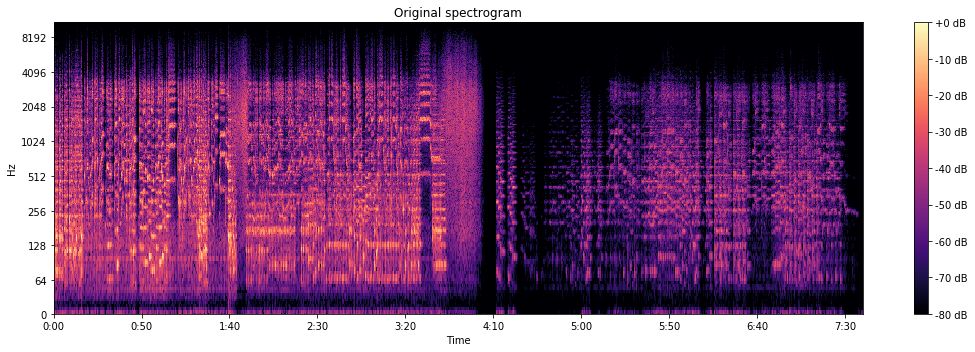

In [69]:
x, fs = librosa.load('opera/Luciano Pavarotti - Ah Mes Amis.wav')
X = librosa.stft(x, n_fft = 4096, hop_length = 2048)
plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(abs(X),np.max),sr=fs,hop_length=2048,y_axis='log', x_axis='time')
plt.title('Original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Here is the constellation map containing only the spectral peaks. Compare that with the original spectrogram above. It more or less captures the main parts.

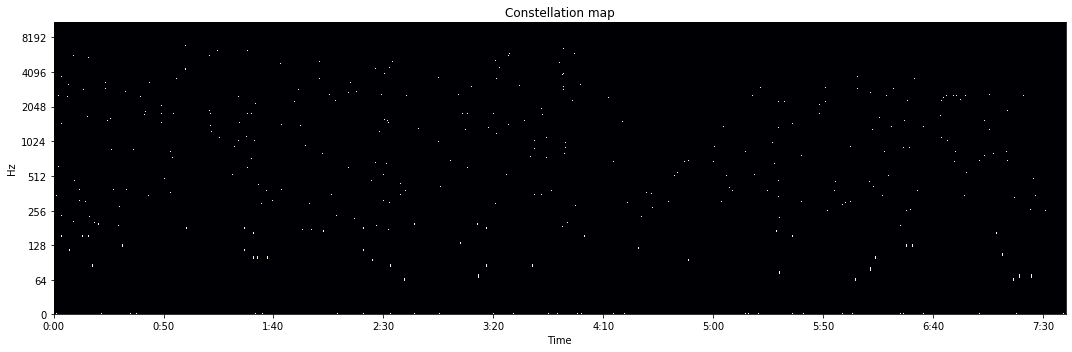

In [70]:
peaks = get_2D_peaks(librosa.amplitude_to_db(abs(X), ref=np.max), True) #constellation map

In [73]:
hashes = generate_hashes(peaks)
print('number of hashes', len(hashes))
print("average number of hashes/sec", int(len(hashes)/(len(x)/fs)))

number of hashes 12320
average number of hashes/sec 26


### Training

In [48]:
song_table = pd.read_csv('song_table.csv', index_col = 0)
song_table

,Name
0,opera/Luciano Pavarotti - Ah Mes Amis.wav
1,opera/群星 - 铁砧合唱.wav
2,opera/常思思 - 炫境.wav
3,opera/Maria Callas - Caro Nome - BlueConvert.c...
4,opera/迪里拜尔 - 鹪鹩(小鸟)(意).wav
5,opera/中国交响乐团附属少年及女子合唱团 - 魔笛序曲(莫扎特曲).wav
6,opera/Natalie Dessay - Giulio Cesare in Egitto...
7,opera/Vivica Genaux - Idaspe ：Qual guerriero i...
8,"opera/Teodor Currentzis,Wolfgang Amadeus Mozar..."
9,opera/Vienna Operatic Orchestra - Non piu andr...


In [14]:
def finger_printing(song_id):
    '''
    Implementation of fingerprinting.
    '''
    x, fs = librosa.load(song_table.loc[song_id, 'Name'])
    X = librosa.stft(x, n_fft = 4096, hop_length = 2048)
    peaks = get_2D_peaks(librosa.amplitude_to_db(abs(X), ref=np.max))
    
    return generate_hashes(peaks)

hash_table = {} #key is the address, and value is a list of (offset, song_id) tuples that contain this address.
for i in range(len(song_table)):
    fingerprints = finger_printing(i)
    for address, offset in fingerprints:
        hash_table[address] = hash_table.get(address,[])+[(offset, i)]

import pickle
picklefile = open('opera_hash_table', 'wb')
pickle the dictionary and write it to file
pickle.dump(hash_table, picklefile)
close the file
picklefile.close()

In [49]:
picklefile = open('opera_hash_table', 'rb')
hash_table = pickle.load(picklefile)
# dict[hash][(ID, offset), (ID, offset)....]

In [50]:
hash_table

{'d2153cc6921cd5973029': [(16, 0),
  (105, 0),
  (968, 0),
  (4509, 0),
  (4550, 0),
  (4619, 0),
  (3425, 3),
  (1767, 6),
  (2478, 6),
  (2006, 7),
  (4921, 7),
  (1166, 25),
  (1549, 25),
  (2146, 25),
  (2173, 25),
  (3138, 25),
  (1729, 27),
  (1063, 29),
  (1306, 29),
  (1444, 29),
  (1634, 29),
  (16, 31),
  (444, 31),
  (628, 31)],
 'f589f96c64a7a876a9ae': [(16, 0),
  (237, 0),
  (1542, 0),
  (2005, 0),
  (2065, 0),
  (2426, 0),
  (3437, 0),
  (55, 3),
  (215, 6),
  (2218, 6),
  (459, 7),
  (2506, 7),
  (320, 20),
  (776, 20),
  (881, 20),
  (1797, 25),
  (3078, 25),
  (3138, 25),
  (2422, 27),
  (397, 29),
  (566, 29)],
 '47bf6c32af0ac7f37752': [(16, 0),
  (57, 0),
  (180, 0),
  (3254, 0),
  (3776, 0),
  (3297, 3),
  (3311, 3),
  (658, 6),
  (406, 7),
  (2477, 7),
  (3308, 7),
  (1436, 11),
  (941, 20),
  (956, 20),
  (1684, 25),
  (1708, 25),
  (2283, 25),
  (3090, 25),
  (1317, 27),
  (2272, 27),
  (537, 29),
  (1270, 29),
  (1396, 29),
  (1840, 29)],
 '0e0a6fcf137be2f50bd7'

In [66]:
def query(test):
    x, fs = librosa.load(test)
    X = librosa.stft(x, n_fft = 4096, hop_length = 2048)
    peaks = get_2D_peaks(librosa.amplitude_to_db(abs(X), ref=np.max))
    hashes = generate_hashes(peaks)
    
    results = []
    for hash_, offset in hashes:
        try:
            for Aboff, Id in hash_table[hash_]: #find values that contain this hash_ address
                results.append((Id, Aboff-offset)) #gather the songID, as well the time difference
                # between the recording's offset and the absolute offset in the matched one
        except KeyError:
            pass
    results.sort()

    matches = Counter(results).most_common(10) # find best matches
    output = []
    for match in matches:
        output.append((song_table.loc[match[0][0], 'Name'],match[0],match[1]))
    return output

### Testing

In [67]:
test='opera/Luciano Pavarotti - Ah Mes Amis.wav'
query(test) # the exact track is contained in the databsae

[('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, 0), 12320),
 ("opera/Orchestre Paul Kuentz,Elisabeth Vidal - Les oiseaux dans la charmille (Extrait des Contes d'Offmann).wav",
  (25, -611),
  18),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, -14), 16),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, 14), 16),
 ("opera/Orchestre Paul Kuentz,Elisabeth Vidal - Les oiseaux dans la charmille (Extrait des Contes d'Offmann).wav",
  (25, -1978),
  14),
 ("opera/Orchestre Paul Kuentz,Elisabeth Vidal - Les oiseaux dans la charmille (Extrait des Contes d'Offmann).wav",
  (25, -1196),
  14),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, -732), 13),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, -327), 13),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, 327), 13),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, 732), 13)]

In [68]:
test2='TheBrindisi(Drinking Song) from La Traviata - BlueConvert.com.wav'
query(test2) # this version is not contained in the database, but the same piece

[('opera/Giuseppe Verdi - 《茶花女》饮酒歌.wav', (12, -615), 6),
 ("opera/Orchestre Paul Kuentz,Elisabeth Vidal - Les oiseaux dans la charmille (Extrait des Contes d'Offmann).wav",
  (25, -1261),
  6),
 ("opera/Orchestre Paul Kuentz,Elisabeth Vidal - Les oiseaux dans la charmille (Extrait des Contes d'Offmann).wav",
  (25, -686),
  5),
 ('opera/Luciano Pavarotti - Ah Mes Amis.wav', (0, 755), 4),
 ('opera/Claudio Abbado - Le nozze di Figaro, K.492 ／ Appendix：Un moto di gioia (Susanna).wav',
  (11, -1594),
  4),
 ('opera/Furyl,4_Chords - 【FREE】Butterfly.wav', (17, -1571), 4),
 ('opera/Furyl,4_Chords - 【FREE】Butterfly.wav', (17, -1397), 4),
 ('opera/Hoelierthanthou - Eminem-D1ss（將敌TcT remix）.wav', (24, -1603), 4),
 ('opera/Hoelierthanthou - Eminem-D1ss（將敌TcT remix）.wav', (24, -1277), 4),
 ('opera/Hoelierthanthou - Eminem-D1ss（將敌TcT remix）.wav', (24, -1082), 4)]

Both tests were shown to be successful. Test1 has especially demonstrated that for existing songs in the database, the algorithm performance is highly strong. 